# Predictions of solar energy production using LSTM architecture with the attention mechanism

---



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

In [2]:
def reg_data(df):
    # Drop the first three rows of the DataFrame
    df = df.drop(df.index[[0, 1, 2]])
    # Drop the 'MW' column
    df = df.drop('MW', axis=1)
    # Rename the columns for easier reference
    df.columns = ['Date', 'From', 'to', 'MW']

    # Split the Date column into Day, Month, and Year
    dates = df['Date'].tolist()
    days, months, years = [], [], []
    for date in dates:
        day, month, year = date.split('.')
        days.append(int(day))
        months.append(int(month))
        years.append(int(year))

    # Assign new columns to the DataFrame
    df['Day'] = days
    df['Month'] = months
    df['Year'] = years

    # Clean and convert the MW column to float
    def fixMW(value):
        value = value.replace('.', '')
        value = value.replace(',', '.')
        return float(value)

    df['MW'] = df['MW'].apply(fixMW)

    # Group by Day, Month, and Year and sum the MW values
    df = df.groupby(['Day', 'Month', 'Year'])['MW'].sum().reset_index()

    # Create a new Date column for sorting
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Sort the DataFrame by the new Date column
    df = df.sort_values(by='Date')

    # Drop the Date column and reorder the remaining columns
    df = df.drop(columns='Date')
    df = df[['MW', 'Day', 'Month', 'Year']]

    return df

# Load the CSV files, apply the reg_data function, and store the results in variables
Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv', sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv', sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv', sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv', sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv', sep=';')
Data_14 = reg_data(Data_14)

Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv', sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv', sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv', sep=';')
Data_17 = reg_data(Data_17)

Data_18 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2018.csv', sep=';')
Data_18 = reg_data(Data_18)

Data_19 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2019.csv', sep=';')
Data_19 = reg_data(Data_19)

Data_20 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2020.csv', sep=';')
Data_20 = reg_data(Data_20)

# Concatenate all the DataFrames into a single DataFrame
DataFrame = pd.concat([Data_10, Data_11, Data_12, Data_13, Data_14, Data_15, Data_16, Data_17, Data_18, Data_19, Data_20], ignore_index=True)


In [40]:
DataFrame

,MW,Day,Month,Year
0,332.0,1,1,2010
1,322.0,2,1,2010
2,163.0,3,1,2010
3,103.0,4,1,2010
4,165.0,5,1,2010
...,...,...,...,...
3937,83307.0,12,10,2020
3938,94011.0,13,10,2020
3939,20041.0,14,10,2020
3940,29126.0,15,10,2020


from matplotlib import pyplot as plt
DataFrame['MW'].plot(kind='hist', bins=20, title='MW')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Day'].plot(kind='hist', bins=20, title='Day')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Month'].plot(kind='hist', bins=20, title='Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame.plot(kind='scatter', x='MW', y='Day', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame.plot(kind='scatter', x='Day', y='Month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
DataFrame.plot(kind='scatter', x='Month', y='Year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['MW']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = DataFrame.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('MW')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Day']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = DataFrame.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Day')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Month']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = DataFrame.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Month')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = DataFrame.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
DataFrame['MW'].plot(kind='line', figsize=(8, 4), title='MW')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Day'].plot(kind='line', figsize=(8, 4), title='Day')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Month'].plot(kind='line', figsize=(8, 4), title='Month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
DataFrame['Year'].plot(kind='line', figsize=(8, 4), title='Year')
plt.gca().spines[['top', 'right']].set_visible(False)

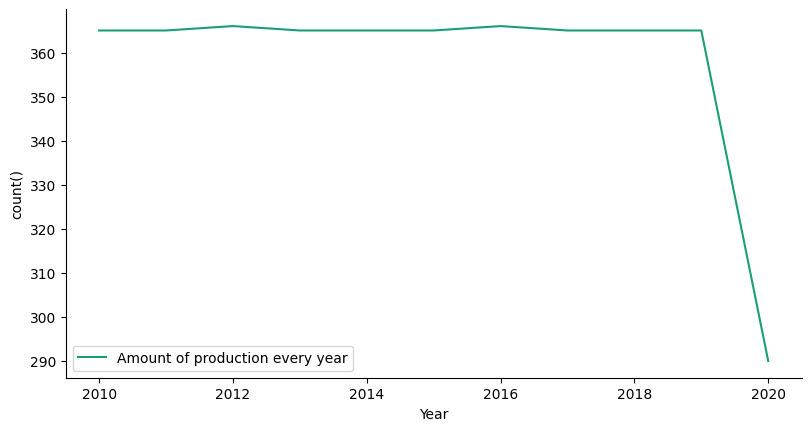

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(8, 4.2), layout='constrained')
df_sorted = DataFrame.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')
ax.legend(["Amount of production every year"])

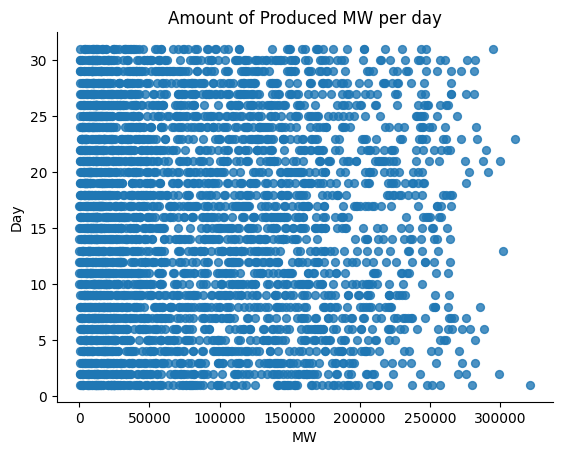

In [57]:
from matplotlib import pyplot as plt
DataFrame.plot(kind='scatter', x='MW', y='Day', s=32, alpha=.8, title = "Amount of Produced MW per day")
plt.gca().spines[['top', 'right',]].set_visible(False)

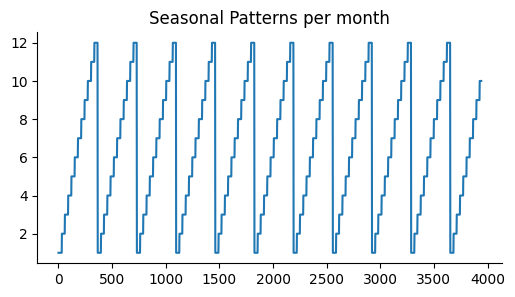

In [59]:
DataFrame['Month'].plot(kind='line', figsize=(6, 3), title='Seasonal Patterns per month')
plt.gca().spines[['top', 'right']].set_visible(False)


> We can see that production is at its peak in the last months of the year (10-11-12)





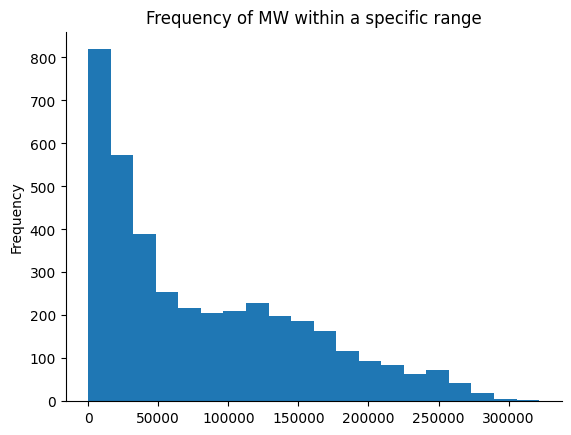

In [62]:
DataFrame['MW'].plot(kind='hist', bins=20, title='Frequency of MW within a specific range')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### We can reasonably conclude that the majority of companies in our dataset have an average production rate between 0 to 50,000 MW.

In [4]:
# Copy the data to preserve the original and work only with the copy
model_data = DataFrame

# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

# Create a function to split the data into train and test sets
def split_data(df):
    # Define the size of the training set as 75% of the data
    train_size = int(len(df) * 0.75)
    # Define the size of the test set with the remaining data
    test_size = len(df) - train_size
    # Split the data into training and test sets
    train, test = df[0:train_size, :], df[train_size:len(df), :]
    return train, test

# Call the "split_data" function to split the data
train, test = split_data(model_data)

# Print the sizes of the data sets
print(len(model_data))  # Total size of the data
print(len(train))       # Size of the training set
print(len(test))        # Size of the test set


3942
2956
986


In [5]:
# Create a function to split the data into Xtrain and Ytrain, and Xtest and Ytest
def Split_weekly(df, look_back=7):
    dataX, dataY = [], []
    # Iterate over the data to create sequences of length 'look_back' for X and the corresponding value for Y
    for i in range(len(df) - look_back - 1):
        a = df[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(df[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Call the Split_weekly function
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

# Print the sizes of the test sets
print(len(Xtest))  # Number of test sequences
print(len(Ytest))  # Number of test targets

# Print the sizes of the training sets
print(len(Xtrain))  # Number of training sequences
print(len(Ytrain))  # Number of training targets


978
978
2948
2948


In [6]:
from keras import layers
from keras.optimizers import Nadam
from keras import layers
from keras.optimizers import Nadam
from keras.models import Model
from keras.optimizers import AdamW


In [7]:
# Function to calculate attention weights
def attention(query, key, value):
    # Calculate the dot product between query and key to get the attention scores
    scores = layers.Dot(axes=[2, 2])([query, key])
    # Scale the attention scores by the square root of the dimension of the key
    scores = scores / np.sqrt(key.shape[-1])
    # Apply the softmax function to get the attention weights
    scores = layers.Softmax(axis=2)(scores)
    # Calculate the context vector as the weighted sum of the value vectors
    context = layers.Dot(axes=[2, 1])([scores, value])
    return context


In [33]:
# Define the model with attention
class AttentionLSTM(Model):
  def __init__(self, sequence_length, units):
    super(AttentionLSTM, self).__init__()
    # A Dense layer with an output dimension of 8
    self.dense1 = layers.Dense(8, input_shape=(sequence_length,))
    # LSTM layers with dropout for regularization
    self.lstm1 = layers.LSTM(units, return_sequences=True)
    self.dropout1 = layers.Dropout(0.3)
    self.lstm2 = layers.LSTM(units, return_sequences=True)
    self.dropout2 = layers.Dropout(0.3)
    self.lstm3 = layers.LSTM(units, return_sequences=True)
    self.dropout3 = layers.Dropout(0.3)
    # Dense layers for the attention mechanism
    self.w1 = layers.Dense(units)
    self.w2 = layers.Dense(units)
    self.v = layers.Dense(1)
    # Final Dense layer for the output
    self.dense = layers.Dense(1, activation='sigmoid')

  # This function defines the forward pass, it gets automatically called when you instantiate the model.
  def call(self, inputs, return_attention=False):
    # Pass the inputs through the dense layer
    inputs = self.dense1(inputs)
    # Add an extra dimension
    inputs = tf.expand_dims(inputs, -1)

    # Pass the inputs through the LSTM layers with dropout
    lstm_output = self.dropout1(self.lstm1(inputs))
    lstm_output = self.dropout2(self.lstm2(lstm_output))
    lstm_output = self.dropout3(self.lstm3(lstm_output))

    # Compute the attention weights
    w1_output = self.w1(lstm_output)
    w2_output = self.w2(inputs)
    attention_weights = self.v(layers.Activation('tanh')(layers.Add()([w1_output, w2_output])))
    attention_weights = layers.Softmax(axis=1)(attention_weights)
    # Compute the context vector using the attention function
    context = attention(w1_output, w2_output, lstm_output)

    # Combine the context vector with the LSTM output
    output = layers.concatenate([context, lstm_output])
    # Pass the combined output through the final dense layer
    output = self.dense(output)
    if return_attention:
      return output, attention_weights
    return output

  def attention(self, w1_output, w2_output, lstm_output):
    attention_weights = self.v(layers.Activation('tanh')(layers.Add()([w1_output, w2_output])))
    attention_weights = layers.Softmax(axis=1)(attention_weights)
    context = tf.reduce_sum(attention_weights * lstm_output, axis=1)
    return context

# Create and train the model
model = AttentionLSTM(7, 8)
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')


In [9]:
# Train the LSTM model with attention
model_train_LSTM_with_Attention = model.fit(
    Xtrain,                        # Training data (input features)
    Ytrain.reshape(-1, 1),         # Training labels, reshaped to match expected dimensions
    validation_split=0.2,          # Use 20% of the training data for validation
    epochs=100,                    # Number of epochs to train the model
    batch_size=8,                  # Number of samples per gradient update
    verbose=1                      # Verbosity mode (1 = progress bar)
)


Epoch 1/100


295/295 [==============================] - 14s 16ms/step - loss: 0.0416 - val_loss: 0.0350
Epoch 2/100
295/295 [==============================] - 4s 12ms/step - loss: 0.0100 - val_loss: 0.0128
Epoch 3/100
295/295 [==============================] - 3s 11ms/step - loss: 0.0069 - val_loss: 0.0124
Epoch 4/100
295/295 [==============================] - 3s 10ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 5/100
295/295 [==============================] - 4s 13ms/step - loss: 0.0064 - val_loss: 0.0119
Epoch 6/100
295/295 [==============================] - 3s 11ms/step - loss: 0.0061 - val_loss: 0.0122
Epoch 7/100
295/295 [==============================] - 3s 11ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 8/100
295/295 [==============================] - 3s 11ms/step - loss: 0.0057 - val_loss: 0.0114
Epoch 9/100
295/295 [==============================] - 4s 14ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 10/100
295/295 [==============================] - 3s 10ms/step - loss: 0.0057 - val_los

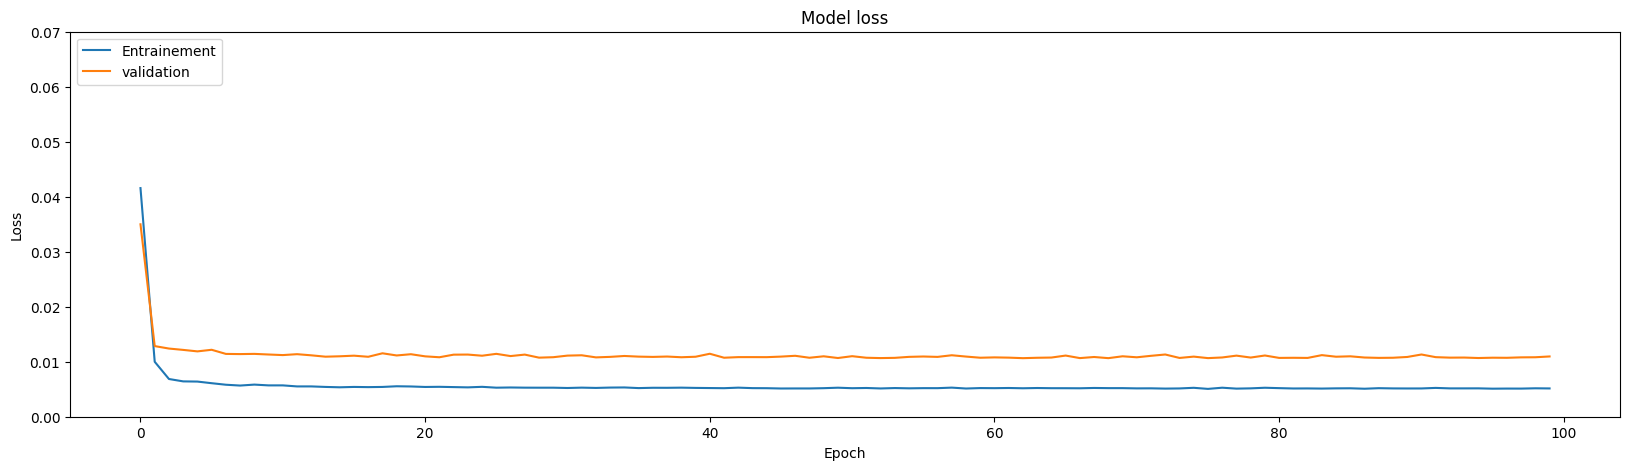

In [10]:
# Define a function to plot training and validation loss
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1, 1, figsize=(20, 5))  # Create a subplot with specified size

    plt.plot(hist.history['loss'])                  # Plot training loss
    plt.plot(hist.history['val_loss'])              # Plot validation loss
    axarr.set_title('Model loss')                   # Set the title of the plot
    axarr.set_ylabel('Loss')                        # Set the y-axis label
    axarr.set_xlabel('Epoch')                       # Set the x-axis label
    axarr.legend(['Entrainement', 'validation'],    # Add a legend with labels for training and validation
                 loc='upper left')                  # Position the legend at the upper left

    axarr.set_ylim([0, 0.07])                       # Set the y-axis limit for better visualization
    plt.show()                                      # Display the plot

# Call the function to plot training and validation loss
ploter_Erreur(model_train_LSTM_with_Attention)


In [11]:
# Define a function to evaluate the model using R^2 score and mean squared error
def evaluate_model(model, X, Y):
    # Make predictions
    predictions = model.predict(X)
    predictions = predictions[:, 0, 0]  # Flatten predictions to match the shape of Y

    # Calculate R^2 score
    r2 = r2_score(Y, predictions)

    # Calculate mean squared error
    mse = mean_squared_error(Y, predictions)

    return r2, mse


In [12]:
# Evaluate the model on training data
r2_train, mse_train = evaluate_model(model, Xtrain, Ytrain)
print("Train MSE:", mse_train)
print("Train R2:", r2_train)

# Evaluate the model on testing data
r2_test, mse_test = evaluate_model(model, Xtest, Ytest)
print("Test MSE:", mse_test)
print("Test R2:", r2_test)


93/93 [==============================] - 4s 6ms/step
Train MSE: 0.00625637178172947
Train R2: 0.8072014824895193
31/31 [==============================] - 0s 6ms/step
Test MSE: 0.025254213880361545
Test R2: 0.6255400712103061


31/31 [==============================] - 0s 6ms/step
(978,)


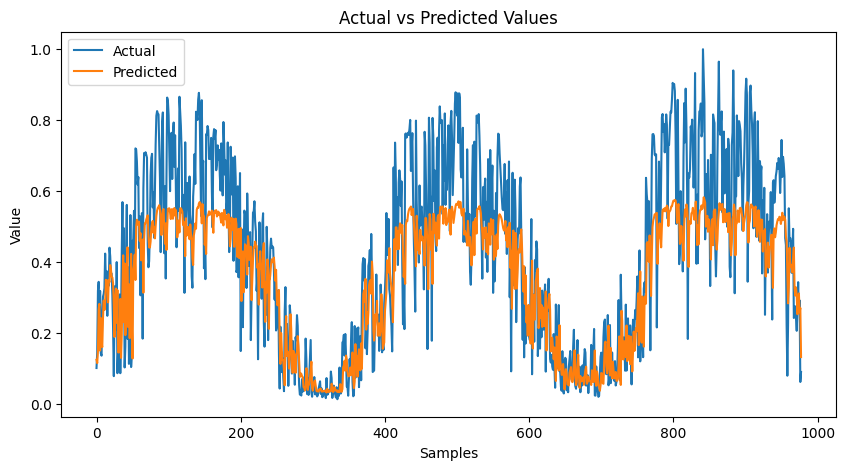

In [19]:
# Make predictions
Ypred = model.predict(Xtest)
Ypred = Ypred[:, 0, 0]  # Flatten predictions to match the shape of Ytest

# Print the shapes of the predictions and targets
print(Ypred.shape)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(Ytest, label='Actual')
plt.plot(Ypred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


<Figure size 1000x500 with 0 Axes>

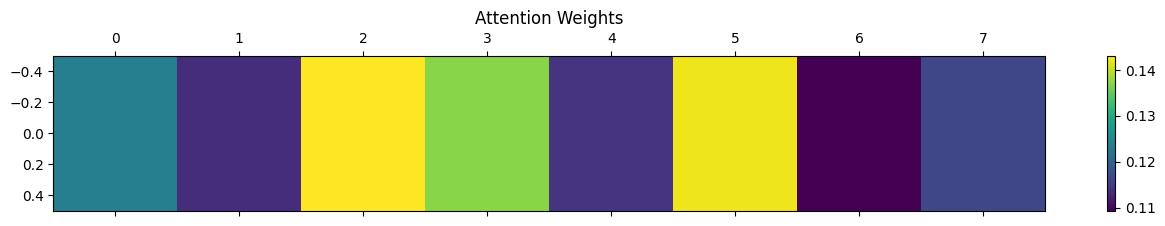

In [34]:
# Plot attention weights
def plot_attention_weights(Xsample, attention_weights):
    plt.figure(figsize=(10, 5))
    plt.matshow(attention_weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Attention Weights')
    plt.show()

# Select a sample input
Xsample = Xtest[0:1]  # First sample
_, attention_weights = model.call(Xsample, return_attention=True)
plot_attention_weights(Xsample, attention_weights)

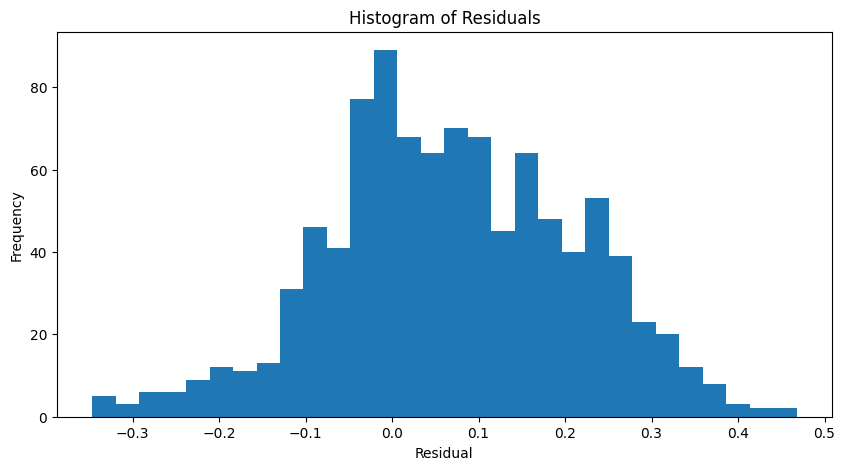

In [22]:
# Compute residuals
residuals = Ytest - Ypred

# Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()
